## Recursive feature elimination with Feature-engine

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

## A) Classification

In [2]:
# load dataset
data = pd.read_csv('../dataset_1.csv')
data.shape

(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Remove constant, quasi-constant and duplicated features

In [5]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

### Recursive Feature Elimination

In [6]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

In [7]:
# Setup the RFE selector

sel = RecursiveFeatureElimination(
    variables=None,
    estimator = model,
    scoring = 'roc_auc',
    threshold = 0.0005,
    cv=5,
)

# this may take quite a while


sel.fit(X_train, y_train)

RecursiveFeatureElimination(cv=5,
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=10),
                            threshold=0.0005)

In [8]:
# performance of model trained using all features

sel.initial_model_performance_

0.7986061325617309

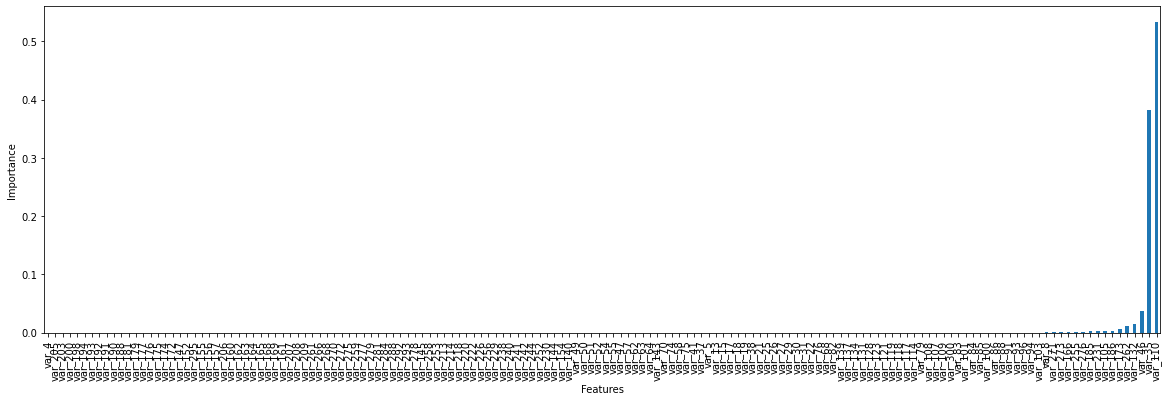

In [9]:
# importance of all features based of initial model

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

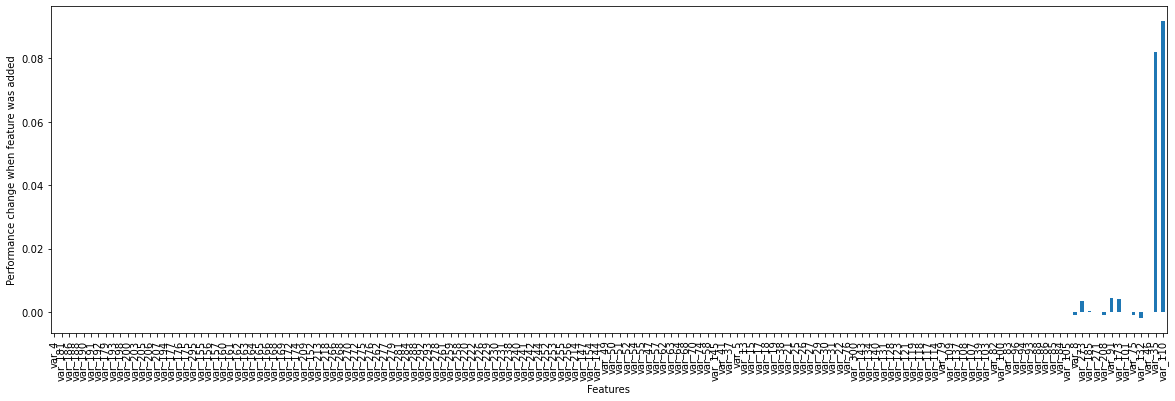

In [10]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [10]:
# Number of features that will be removed

len(sel.features_to_drop_)

145

In [11]:
# select features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((35000, 7), (15000, 7))

In [12]:
# for comparison, fit the model with the selected features
model.fit(X_train, y_train)

# make predictions
y_pred_test = model.predict_proba(X_test)[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.806457


The Gradient Boosting model built with 5 features shows a similar performance than the one built the full dataset.

## B) Regression

In [13]:
# load dataset

data = pd.read_csv('../houseprice.csv')
data.shape

(1460, 81)

In [14]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [15]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 36), (438, 36))

In [16]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Recursive Feature Elimination

In [17]:
# build initial model using all the features
model = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# Setup the RFE selector
sel = RecursiveFeatureElimination(
    variables=None,
    estimator = model, 
    scoring = 'r2', 
    threshold = 0.001, 
    cv=3, 
)

# this may take quite a while,

sel.fit(X_train, y_train)

RecursiveFeatureElimination(estimator=GradientBoostingRegressor(max_depth=4,
                                                                n_estimators=10,
                                                                random_state=10),
                            scoring='r2', threshold=0.001)

In [18]:
# performance of model trained using all features

sel.initial_model_performance_

0.7007152795529389

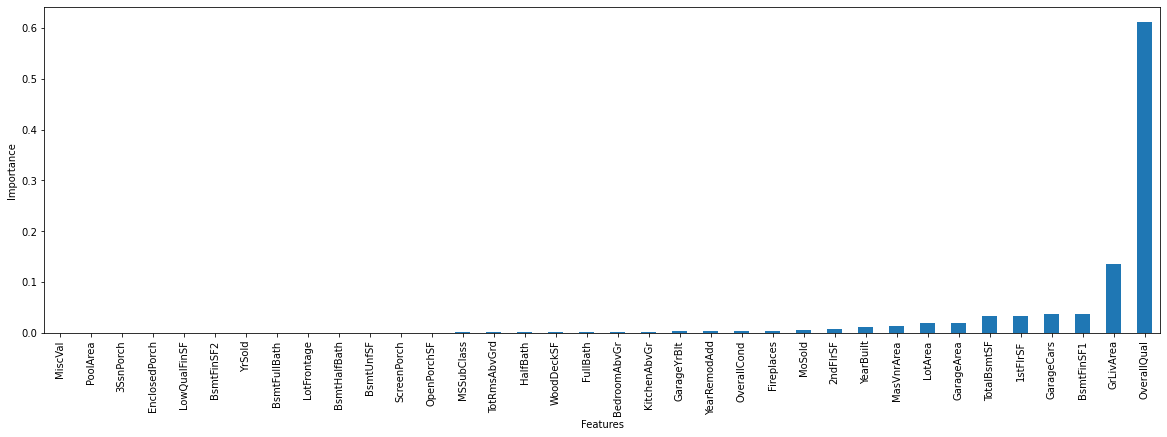

In [19]:
# importance of all features based of initial model

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

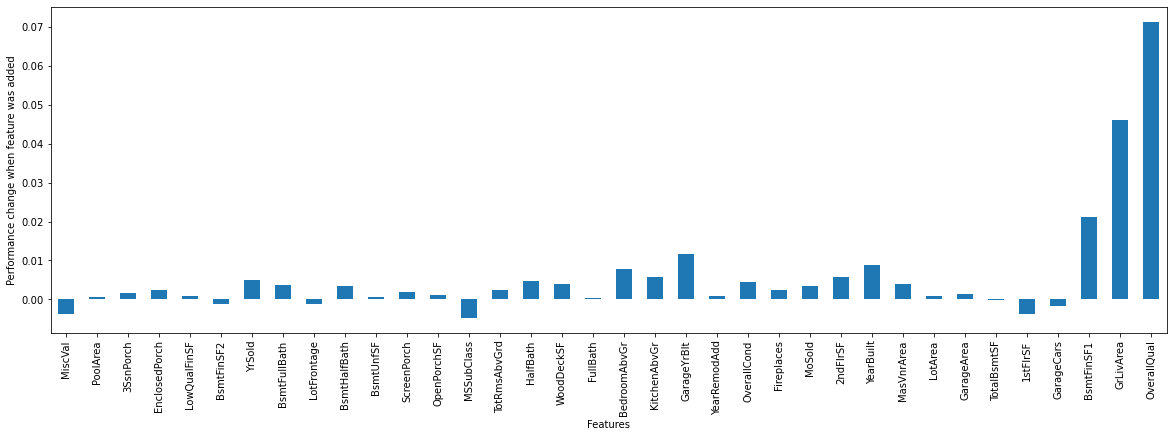

In [20]:
pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [21]:
# number of features that will be removed

len(sel.features_to_drop_)

13

In [22]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((1022, 23), (438, 23))

In [23]:
# test the performance of the model built on the selected features

# fit the model with the selected features
model.fit(X_train, y_train)

# make predictions
y_pred_test = model.predict(X_test)

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.724467


The model built with 23 features shows similar or slightly better performance.